<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#My-Func" data-toc-modified-id="My-Func-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>My Func</a></span></li><li><span><a href="#Var-Review" data-toc-modified-id="Var-Review-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Var Review</a></span><ul class="toc-item"><li><span><a href="#Raw-Distribution" data-toc-modified-id="Raw-Distribution-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Raw Distribution</a></span></li><li><span><a href="#Current-Function-Output" data-toc-modified-id="Current-Function-Output-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Current Function Output</a></span></li></ul></li><li><span><a href="#Reviewing-New-Distributions-for-Random-Fill" data-toc-modified-id="Reviewing-New-Distributions-for-Random-Fill-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reviewing New Distributions for Random Fill</a></span><ul class="toc-item"><li><span><a href="#Log-Normal-Distribution" data-toc-modified-id="Log-Normal-Distribution-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Log-Normal Distribution</a></span></li><li><span><a href="#Loggamma-Distribution" data-toc-modified-id="Loggamma-Distribution-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loggamma Distribution</a></span></li></ul></li><li><span><a href="#New-Function" data-toc-modified-id="New-Function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>New Function</a></span></li><li><span><a href="#Reviewing-the-New-Function" data-toc-modified-id="Reviewing-the-New-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Reviewing the New Function</a></span></li></ul></div>

# Test File

In [1]:
# %load Imports.py
#Imports
##Mine
import sys
sys.path.append('../')
from Cleaning import update_regions

##General
import pandas as pd
import numpy as np

##Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline


## Data

In [2]:
X_train_raw = pd.read_csv("../Data/Raw/Train.csv")
X_train_processed = pd.read_csv("../Data/Final/Train1.csv")
y_train = pd.read_csv("../Data/Raw/Train_Labels.csv")

In [3]:
X_train_processed['status_group'] = y_train['status_group'].copy()

In [4]:
X_train_raw['status_group'] = y_train['status_group'].copy()

In [5]:
X_train_raw = update_regions(X_train_raw)

## My Func

In [6]:
def fill_construction_year(data, test = False, train_data = None):
    #Filling based on the mean value of the Wards
    #if the ward is 0 then by the district
    #If district is 0 then leave 0, as these are far enough apart, I don't think they should be filled across regions
    regions = data[data['construction_year'] > 0]['region'].unique()
    #Setting up group object of means
    #If training data was supplied:
    if test:
        means_wards = train_data[train_data['construction_year'] > 0]['construction_year'].groupby([train_data['region'], train_data['lga'], train_data['ward']]).describe()
        means_lga = train_data[train_data['construction_year'] > 0]['construction_year'].groupby([train_data['region'], train_data['lga']]).describe()
        mean_overall = int(train_data[train_data['construction_year'] > 0]['construction_year'].mean())
    else:
        means_wards = data[data['construction_year'] > 0]['construction_year'].groupby([data['region'], data['lga'], data['ward']]).describe()
        means_lga = data[data['construction_year'] > 0]['construction_year'].groupby([data['region'], data['lga']]).describe()
        mean_overall = int(data[data['construction_year'] > 0]['construction_year'].mean())

    for i in range(data.shape[0]):
        region = data['region'][i]
        dist = data['lga'][i]
        ward = data['ward'][i]
        if data['construction_year'][i] == 0:
            if data['region'][i] in regions:
                try:
                    #Need the try, as there are entire regions with no amount_tsh values
                    #So these regions would raise a key error if passed to the group objects
                    if means_wards.loc[region, dist, ward]["mean"] != 0:
                        data.loc[i, 'construction_year'] = means_wards.loc[region, dist, ward]["mean"]
                    elif means_lga.loc[region, dist]["mean"] != 0:
                            data.loc[i, 'construction_year'] = means_lga.loc[region, dist]["mean"]
                    else:
                        data.loc[i, 'construction_year'] = mean_overall
                except:
                    try:
                        if means_lga.loc[region, dist]["mean"] != 0:
                            data.loc[i, 'construction_year'] = means_lga.loc[region, dist]["mean"]
                        else:
                            data.loc[i, 'construction_year'] = mean_overall
                    except:
                        data.loc[i, 'construction_year'] = mean_overall
            else:
                data.loc[i, 'construction_year'] = mean_overall
    data['construction_year'] = data['construction_year'].astype("int64")

    return(data)

## Var Review

### Raw Distribution

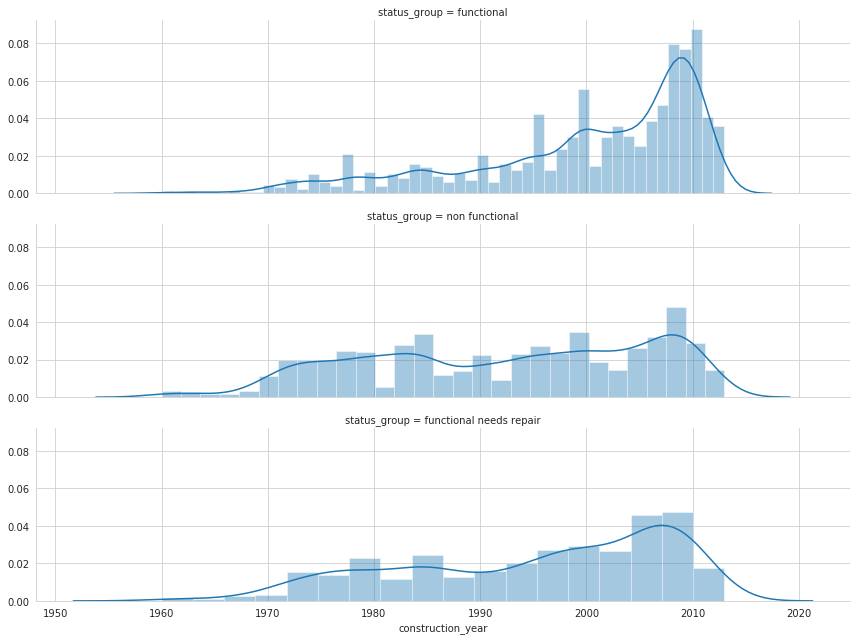

In [7]:
g = sns.FacetGrid(X_train_raw[X_train_raw['construction_year'] > 0], row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year')


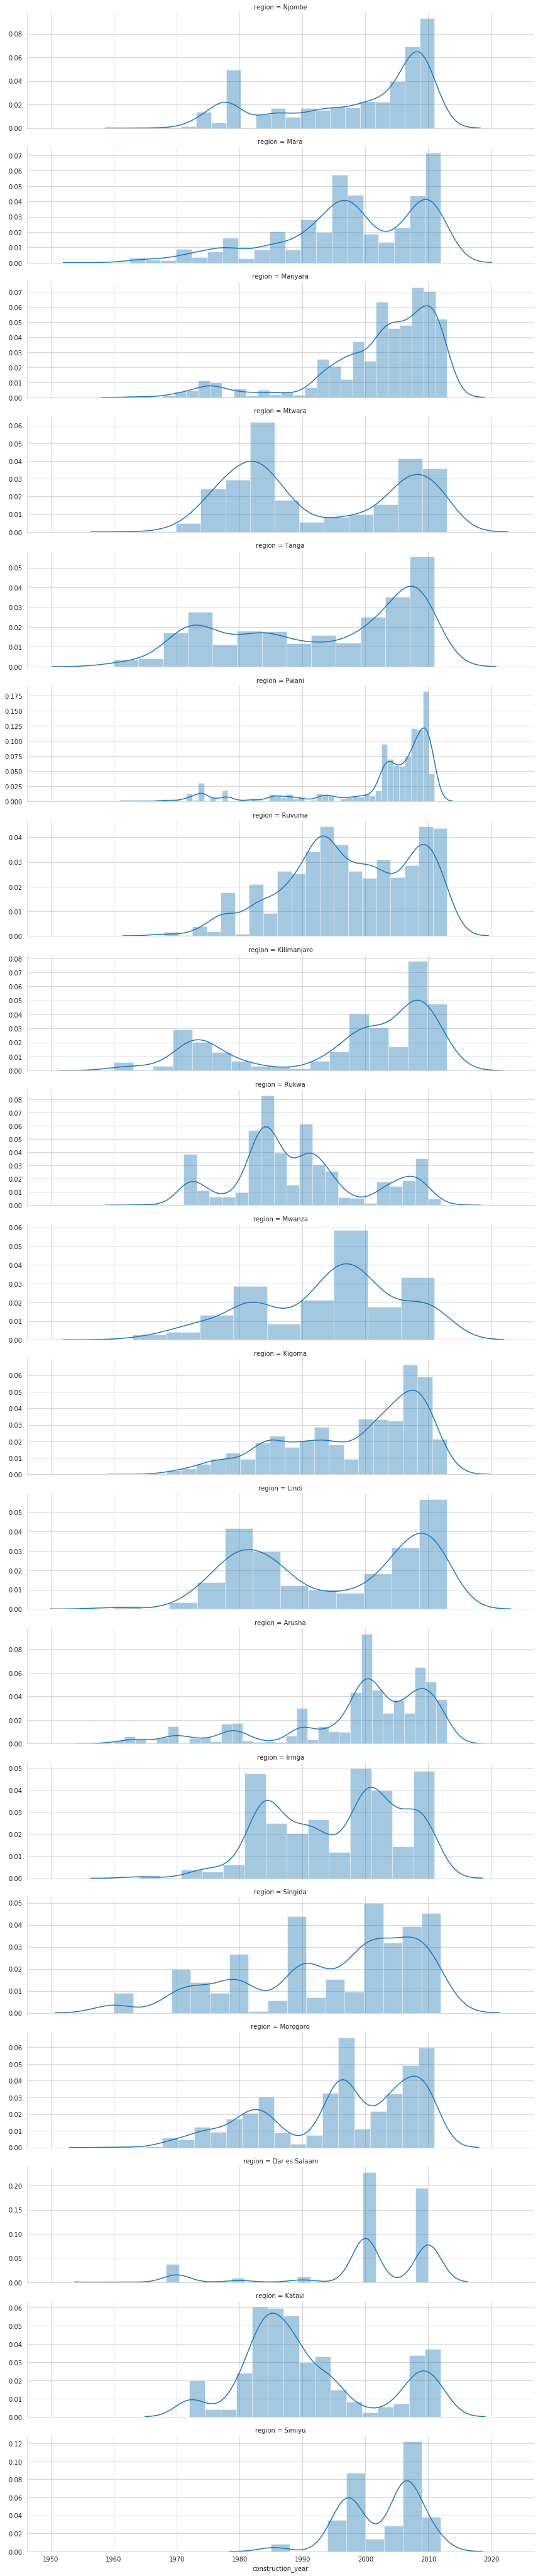

In [8]:
g = sns.FacetGrid(X_train_raw[X_train_raw['construction_year'] > 0], row = 'region', aspect = 4, sharey = False)
g = g.map(sns.distplot, 'construction_year')

In [9]:
X_train_raw[X_train_raw['construction_year'] == 0].groupby(X_train_raw['region'])['region'].count()

region
Arusha             51
Dar es Salaam      17
Dodoma           2201
Geita            1238
Iringa            352
Kagera           3080
Katavi              2
Kigoma             10
Kilimanjaro        35
Lindi             113
Manyara            13
Mara               17
Mbeya            4639
Morogoro           18
Mtwara             87
Mwanza           1995
Njombe             20
Pwani             176
Ruvuma             16
Shinyanga        2014
Simiyu           2554
Singida             8
Tabora           1959
Tanga              94
Name: region, dtype: int64

### Current Function Output

In [10]:
X_train_processed['construction_year'] = X_train_processed['construction_year'].astype('int64').astype('object')

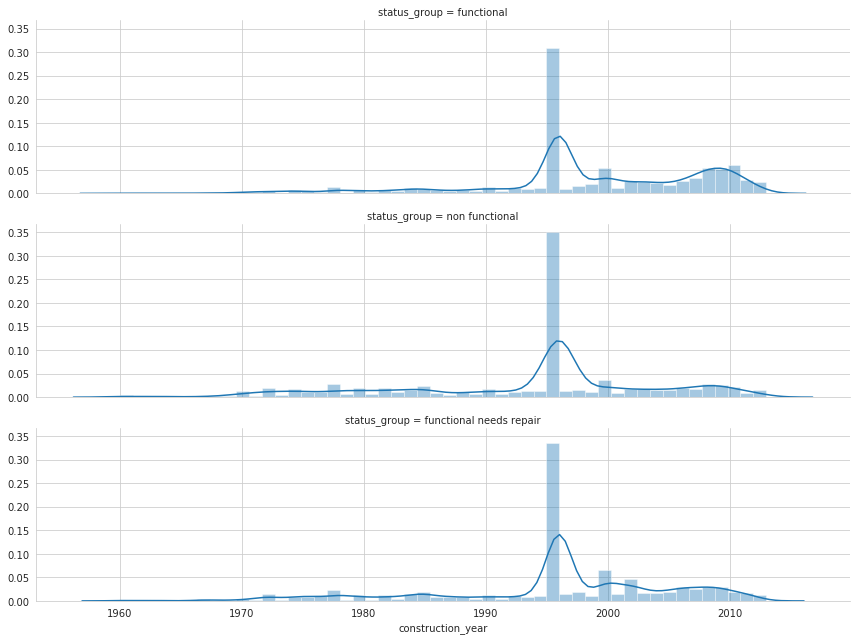

In [11]:
g = sns.FacetGrid(X_train_processed, row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year')
#g.axes[0,0].plot(x, pdf, linewidth = 2, color = 'red')

/home/anna/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/anna/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


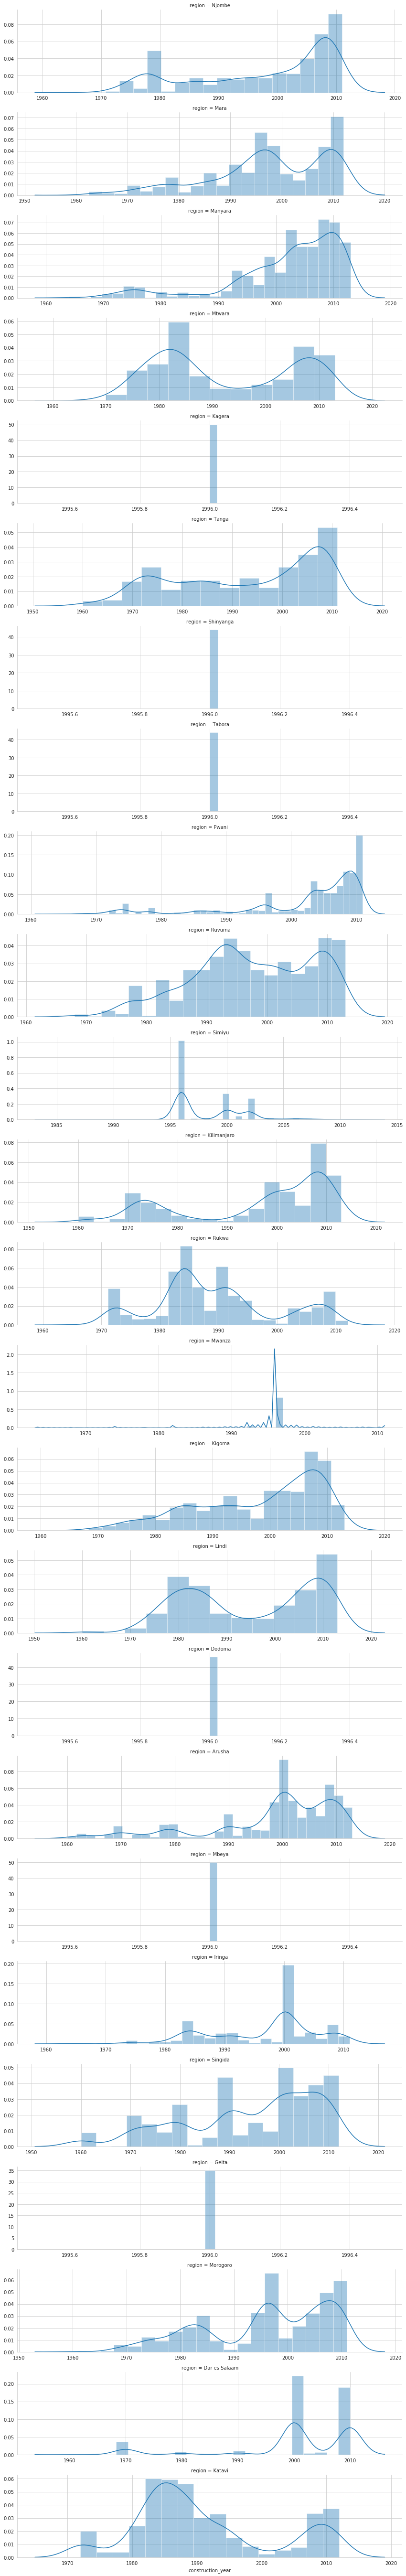

In [12]:
g = sns.FacetGrid(X_train_processed, row = 'region', aspect = 4, sharey = False, sharex = False)
g = g.map(sns.distplot, 'construction_year')

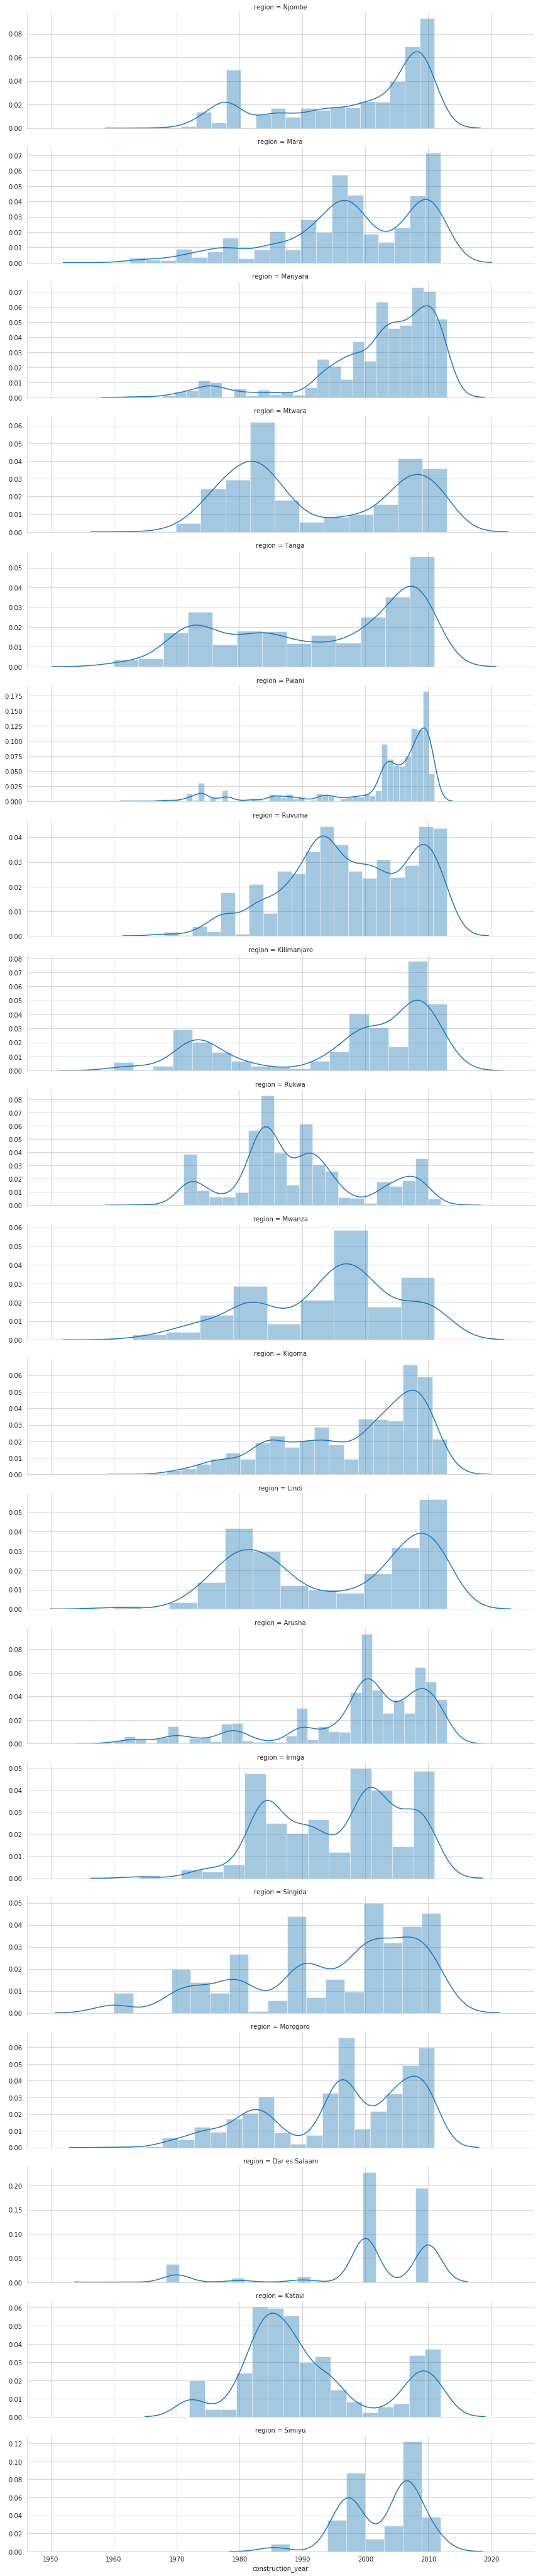

In [13]:
g = sns.FacetGrid(X_train_raw[X_train_raw['construction_year'] > 0], row = 'region', aspect = 4, sharey = False)
g = g.map(sns.distplot, 'construction_year')

## Reviewing New Distributions for Random Fill

**General Means**

In [14]:
means_wards = X_train_raw[X_train_raw['construction_year'] > 0]['construction_year'].groupby([X_train_raw['region'], X_train_raw['lga'], X_train_raw['ward']]).describe()
means_lga = X_train_raw[X_train_raw['construction_year'] > 0]['construction_year'].groupby([X_train_raw['region'], X_train_raw['lga']]).describe()
mean_overall = X_train_raw[X_train_raw['construction_year'] > 0]['construction_year'].mean()
std_overall = X_train_raw[X_train_raw['construction_year'] > 0]['construction_year'].std()

In [15]:
print("The overal mean for the data is {}, and the overall std is {}.".format(mean_overall, std_overall))

The overal mean for the data is 1996.8146855857951, and the overall std is 12.472045035085223.


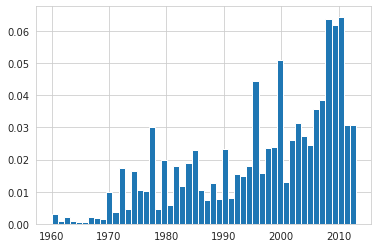

In [16]:
count, bins, ignored = plt.hist(X_train_raw[X_train_raw['construction_year'] > 0]['construction_year'], 50, density=True, align='mid')

### Log-Normal Distribution

In [17]:
x = np.linspace(min(bins), max(bins), 38691)
mu = np.mean(np.log(X_train_raw[X_train_raw['construction_year'] > 0]['construction_year']))
sigma = np.std(np.log(X_train_raw[X_train_raw['construction_year'] > 0]['construction_year']))

In [18]:
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))

**Drawing the Log-Normal curve over the Full Dist of Construction Years** 

Text(0.5, 1.0, 'Histogram of Construction Year')

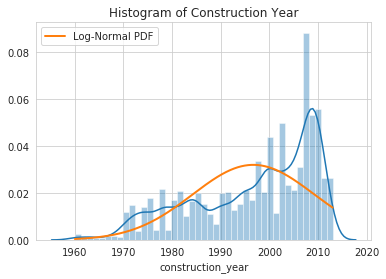

In [19]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(X_train_raw[X_train_raw['construction_year']  >0]['construction_year'])
ax = plt.plot(x, pdf, linewidth = 2, label = "Log-Normal PDF")
plt.legend()
plt.title("Histogram of Construction Year")

**Faceting the Histogram over `status_group` - Log-normal pdf adjusted per group**

In [20]:
#Dictionaries of mu and sigma for each level of `status_group`
mu = {}
sigma = {}
for el in X_train_raw['status_group'].unique():
    mu[el] = np.mean(np.log(X_train_raw[(X_train_raw['construction_year'] > 0) & (X_train_raw['status_group'] == el)]['construction_year']))
    sigma[el] = np.std(np.log(X_train_raw[(X_train_raw['construction_year'] > 0) & (X_train_raw['status_group'] == el)]['construction_year']))

In [21]:
x = []
pdf = []
for i, el in enumerate(mu.keys()):
    x.append(np.linspace(min(bins), max(bins), X_train_raw[(X_train_raw['construction_year'] > 0) & (X_train_raw['status_group'] == el)].shape[0]))
    pdf.append(np.exp(-(np.log(x[i]) - mu[el])**2 / (2 * sigma[el]**2))/ (x[i] * sigma[el] * np.sqrt(2 * np.pi)))

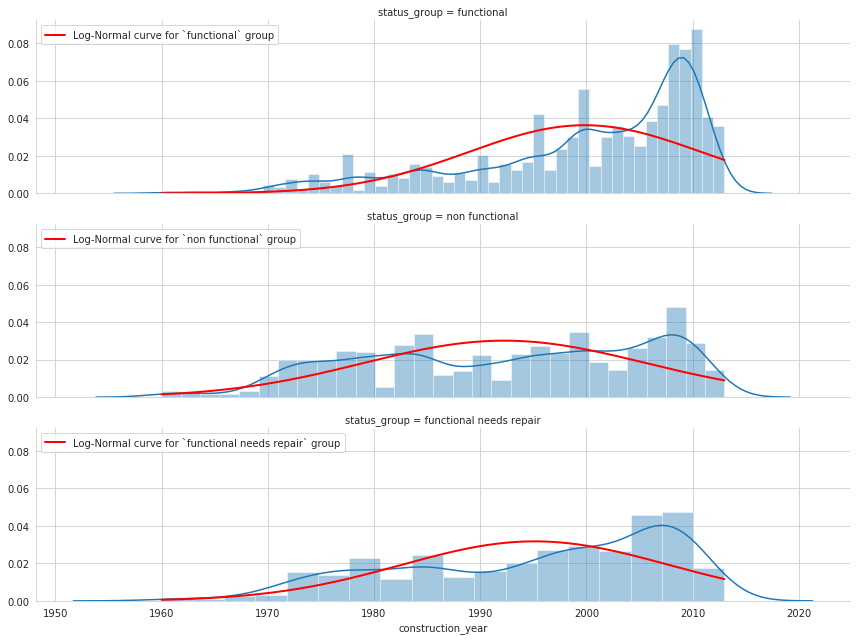

In [22]:
g = sns.FacetGrid(X_train_raw[X_train_raw['construction_year'] > 0], row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year')
for i, el in enumerate(X_train_raw['status_group'].unique()):
    g.axes[i,0].plot(x[i], pdf[i], linewidth = 2, color = 'red', label = "Log-Normal curve for `{}` group".format(el))
    g.axes[i,0].legend(loc = 'upper left')

### Loggamma Distribution

In [23]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import gamma, loggamma, gaussian_kde

In [24]:
X_train_raw_scaled = X_train_raw[X_train_raw['construction_year']>0].copy()

In [25]:
X_train_raw_scaled['construction_year'].describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

In [26]:
stdscal = StandardScaler()

In [27]:
def get_nums(data):
    #List of Numerical Features

    num_feats = []
    for feat in data.dtypes.index:
        if data[feat].dtype == "float64" or data[feat].dtype == "int64":
            num_feats.append(feat)
    return(num_feats)

In [28]:
ints = get_nums(X_train_raw)
ints

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [29]:
X_train_raw_scaled[ints] = stdscal.fit_transform(X_train_raw_scaled[ints])

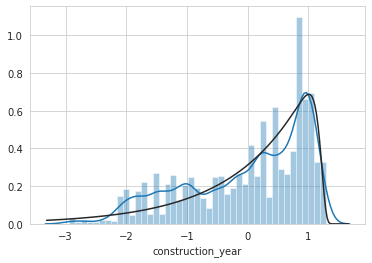

In [30]:
sns.distplot(X_train_raw_scaled['construction_year'], fit = loggamma)

In [31]:
a = np.asarray(X_train_raw_scaled['construction_year'], np.float)
params = loggamma.fit(a)
x = np.linspace(loggamma.ppf(0.01, params[1]),
              loggamma.ppf(0.99, params[1]), 100)

Text(0.5, 1.0, 'Histogram of Construction Year')

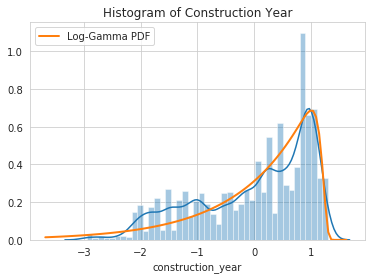

In [32]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(X_train_raw_scaled['construction_year'])
ax = plt.plot(x, loggamma.pdf(x, *params), linewidth = 2, label = "Log-Gamma PDF")
plt.legend()
plt.title("Histogram of Construction Year")

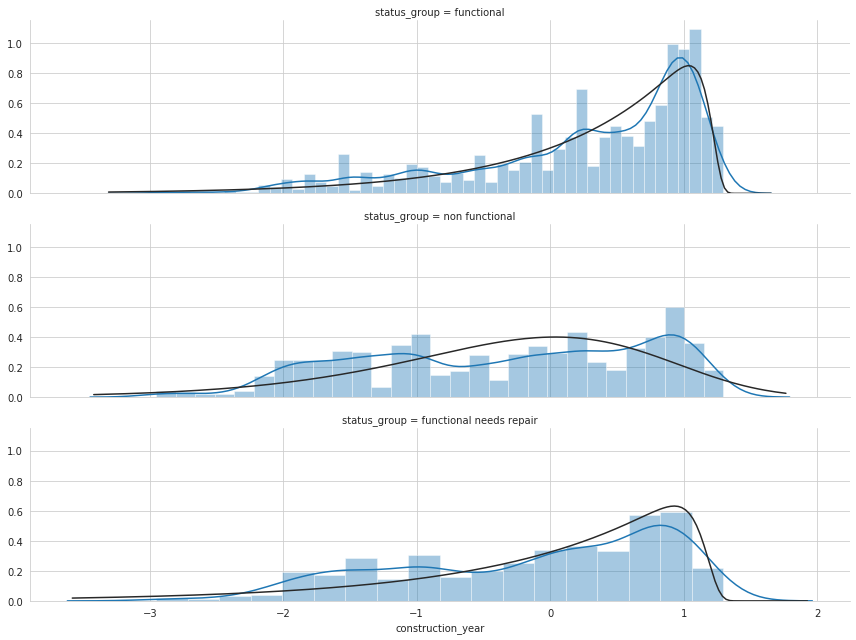

In [33]:
g = sns.FacetGrid(X_train_raw_scaled, row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year', fit = loggamma)

In [34]:
from seaborn.utils import _kde_support
x = {}
pdf = {}
fit_kws = {}
for i, el in enumerate(X_train_raw_scaled['status_group'].unique()):
    a = np.asarray(X_train_raw_scaled[X_train_raw_scaled['status_group'] == el]['construction_year'], np.float)
    params = loggamma.fit(a)
    gridsize = fit_kws.pop("gridsize", 200)
    cut = fit_kws.pop("cut", 3)
    clip = fit_kws.pop("clip", (-np.inf, np.inf))
    bw = gaussian_kde(a).scotts_factor() * a.std(ddof=1)
    x[el] = _kde_support(a, bw, gridsize, cut, clip)
    pdf[el] = loggamma.pdf(x[el], *params)

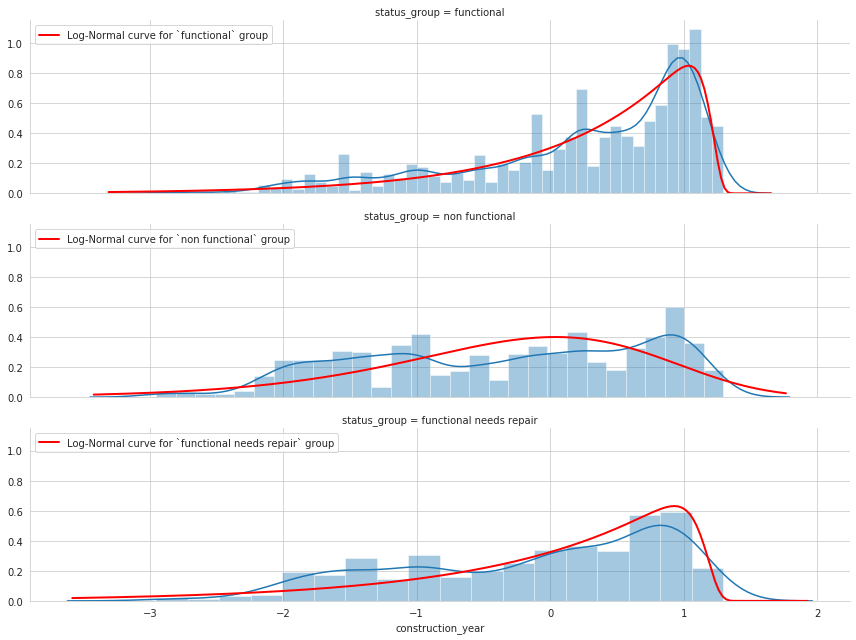

In [35]:
g = sns.FacetGrid(X_train_raw_scaled, row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year')
for i, el in enumerate(X_train_raw_scaled['status_group'].unique()):
    g.axes[i,0].plot(x[el], pdf[el], linewidth = 2, color = 'red', label = "Log-Normal curve for `{}` group".format(el))
    g.axes[i,0].legend(loc = 'upper left')

In [36]:
x = {}
pdf = {}
fit_kws = {}
for i, el in enumerate(X_train_raw_scaled['region'].unique()):
    a = np.asarray(X_train_raw_scaled[X_train_raw_scaled['region'] == el]['construction_year'], np.float)
    params = loggamma.fit(a)
    gridsize = fit_kws.pop("gridsize", 200)
    cut = fit_kws.pop("cut", 3)
    clip = fit_kws.pop("clip", (-np.inf, np.inf))
    bw = gaussian_kde(a).scotts_factor() * a.std(ddof=1)
    x[el] = _kde_support(a, bw, gridsize, cut, clip)
    pdf[el] = loggamma.pdf(x[el], *params)

/home/anna/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1682: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


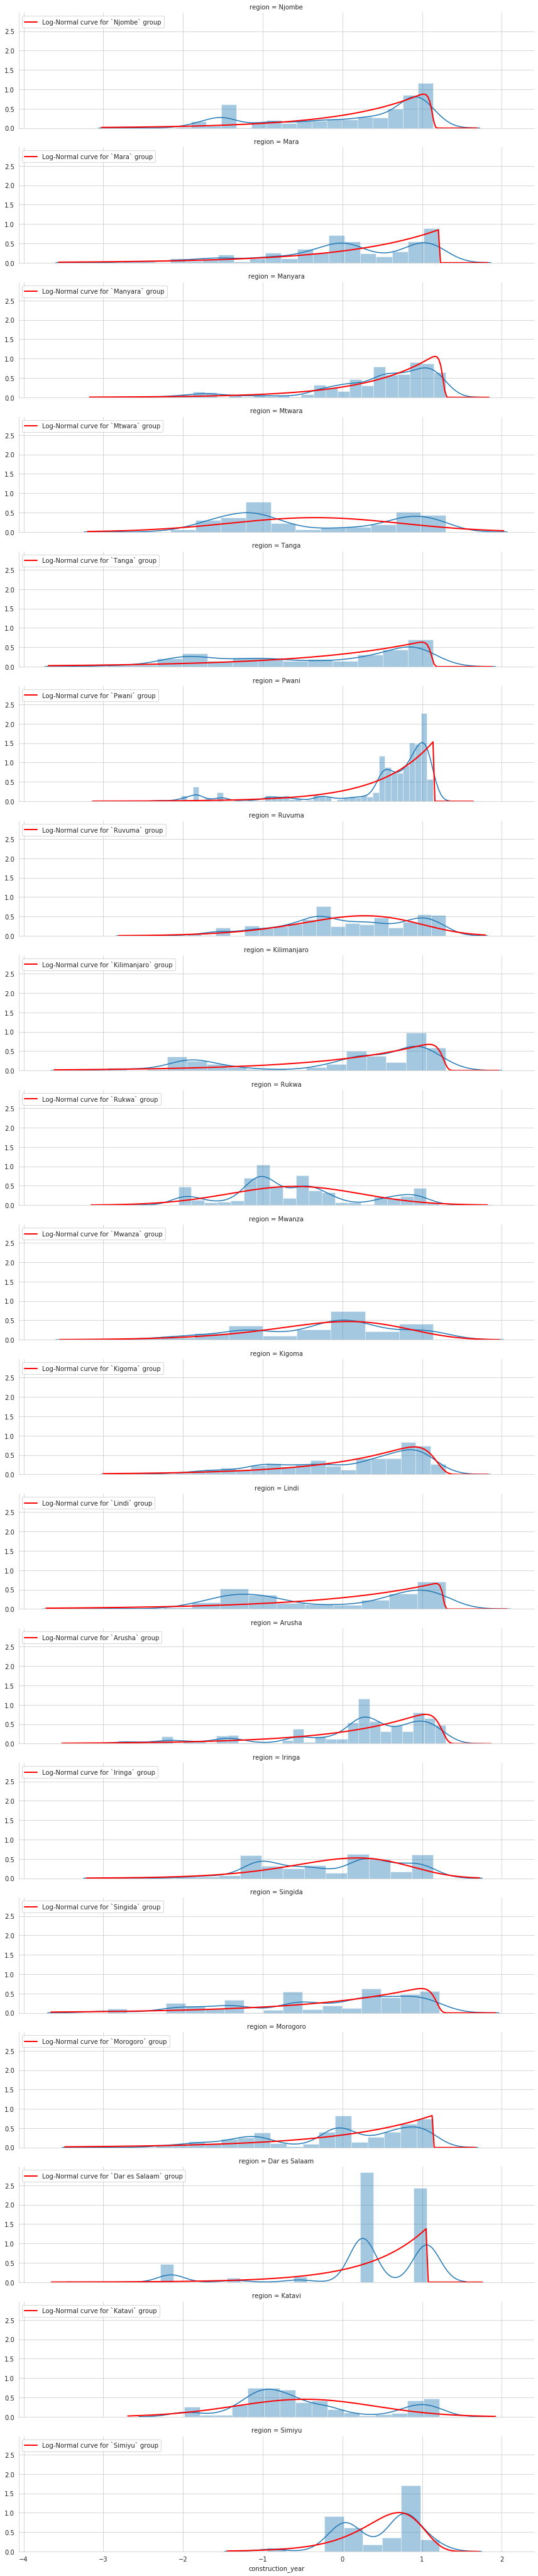

In [37]:
g = sns.FacetGrid(X_train_raw_scaled, row = 'region', aspect = 4)
g = g.map(sns.distplot, 'construction_year')
for i, el in enumerate(X_train_raw_scaled['region'].unique()):
    g.axes[i,0].plot(x[el], pdf[el], linewidth = 2, color = 'red', label = "Log-Normal curve for `{}` group".format(el))
    g.axes[i,0].legend(loc = 'upper left')

Okay, so the loggamma function fits relatively well, so I'll be using it to provide my random estimates of the construction year. That being said, it extends on both tails outside of th range of my data, so I'll need to institute a floor and a ceiling for the estimates.

## New Function

In [38]:
def fill_construction_year(data, train_data = None):
    #Here I'll imput the construction year using two seperate methods
    #1 - If there are ANY non-zero values in the ward or district of interest (I'll check that on the region level)
        #Then I'll fill using the mean of the most granular location information avaliable
    #2 - If there are ONLY zero observations for the entire region, I'll fit a loggamma dist to the data (or training data)
        #And then use a randomly generated imputation value
    
    regions = data[data['construction_year'] > 0]['region'].unique()
    #If training data was supplied (ie, imputing test data):
    if train_data is not None:
        means_wards = train_data[train_data['construction_year'] > 0]['construction_year'].groupby([train_data['region'], train_data['lga'], train_data['ward']]).describe()
        means_lga = train_data[train_data['construction_year'] > 0]['construction_year'].groupby([train_data['region'], train_data['lga']]).describe()
        min_val = min(train_data[train_data['construction_year'] > 0]['construction_year'])
        max_val = max(train_data[train_data['construction_year'] > 0]['construction_year'])
        
        #Creating scaled data for loggamma imputation
        std = StandardScaler()
        ints = get_nums(train_data)
        scaled_data = std.fit_transform(train_data[ints])
        #np array of construction year
        index = [i for i,x in enumerate(ints) if x == 'construction_year']
        a = np.asarray(scaled_data[index[0]], np.float)
        #parameters and x for loggamma imputation
        params = loggamma.fit(a)
        x = np.linspace(loggamma.ppf(0.01, params[1]),
              loggamma.ppf(0.99, params[1]), 100)

    #If working on training data directly
    else:
        means_wards = data[data['construction_year'] > 0]['construction_year'].groupby([data['region'], data['lga'], data['ward']]).describe()
        means_lga = data[data['construction_year'] > 0]['construction_year'].groupby([data['region'], data['lga']]).describe()
        min_val = min(data[data['construction_year'] > 0]['construction_year'])
        max_val = max(data[data['construction_year'] > 0]['construction_year'])
        
        #Creating scaled data for loggamma imputation
        std = StandardScaler()
        ints = get_nums(data)
        scaled_data = std.fit_transform(data[ints])
        #np array of construction year
        index = [i for i,x in enumerate(ints) if x == 'construction_year']
        a = np.asarray(scaled_data[index[0]], np.float)
        #parameters and x for loggamma imputation
        params = loggamma.fit(a)
        x = np.linspace(loggamma.ppf(0.01, params[1]),
              loggamma.ppf(0.99, params[1]), 100)
        
    #Imputation
    for i in range(data.shape[0]):
        region = data['region'][i]
        dist = data['lga'][i]
        ward = data['ward'][i]
        if data['construction_year'][i] == 0:
            #Imputing regions where there is at least one non-zero observation
            if data['region'][i] in regions:
                
                #Using try, as there are wards which are blank in non-zero regions
                #So these regions would raise a key error if passed to the group objects
                try:
                    if means_wards.loc[region, dist, ward]["mean"] != 0:
                        data.loc[i, 'construction_year'] = means_wards.loc[region, dist, ward]["mean"]
                    elif means_lga.loc[region, dist]["mean"] != 0:
                            data.loc[i, 'construction_year'] = means_lga.loc[region, dist]["mean"]
                    else:
                        data.loc[i, 'construction_year'] = mean_overall
                
                #If the ward was blank, fill on the district
                except:
                    try:
                        if means_lga.loc[region, dist]["mean"] != 0:
                            data.loc[i, 'construction_year'] = means_lga.loc[region, dist]["mean"]
                        else:
                            data.loc[i, 'construction_year'] = mean_overall
                    #Again, there may be blank districts in a non-zero region
                    #If so, fill using the loggamma estimate from the all-zero region imputation method below
                    except:
                        fake_data = np.zeros(len(ints))
                        index = [i for i,x in enumerate(ints) if x == 'construction_year']
                        fake_data[index[0]] = loggamma.rvs(*params)
                        imput = stdscal.inverse_transform(fake_data)[index[0]]
                        if imput < min(data[data['construction_year'] > 0]['construction_year']):
                            data.loc[i, 'construction_year'] = min(data[data['construction_year'] > 0]['construction_year'])
                        elif imput > max(data[data['construction_year'] > 0]['construction_year']):
                            data.loc[i, 'construction_year'] = max(data[data['construction_year'] > 0]['construction_year'])
                        else:
                            data.loc[i, 'construction_year'] = imput
            
            #Imputing for regions which have no observations
            #Using a loggamma dist
            else:
                #Since the standard scaler was scaled on 10 features, I need to in_verse transform on ten features as well
                #I only care about the construction_year, so I'll leave the rest as zeros
                fake_data = np.zeros(len(ints))
                #Provides the index of the construction_year in the 'ints' var
                fake_data[index[0]] = loggamma.rvs(*params)
                #imput value, generated under a loggamma dist, transformed back into the original space
                imput = stdscal.inverse_transform(fake_data)[index[0]]
                
                #Loggamma extends past the range of the data, so I'll limit the range of acceptable imputations using the min and max of the training data
                if imput < min_val:
                    data.loc[i, 'construction_year'] = min_val
                elif imput > max_val:
                    data.loc[i, 'construction_year'] = max_val
                else:
                    data.loc[i, 'construction_year'] = imput

            
    data['construction_year'] = data['construction_year'].astype("int64")

    return(data)

In [39]:
X_train_new = fill_construction_year(X_train_raw)

In [43]:
X_train_new['construction_year'].groupby(X_train_new['region']).describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Arusha,3350.0,1998.814328,11.864600,1960.0,1995.0,2001.0,2008.0,2013.0
Dar es Salaam,805.0,2001.095652,10.930788,1960.0,2000.0,2000.0,2010.0,2010.0
Dodoma,2201.0,1993.838255,9.310317,1960.0,1988.0,1994.0,2000.0,2013.0
Geita,1238.0,1994.133279,9.187836,1964.0,1988.0,1994.0,2000.0,2013.0
Iringa,1597.0,1996.532874,9.068851,1964.0,1990.0,2000.0,2001.0,2011.0
Kagera,3080.0,1993.637987,9.474284,1960.0,1987.0,1994.0,2000.0,2013.0
Katavi,679.0,1990.885125,10.756424,1972.0,1984.0,1988.0,1995.0,2012.0
Kigoma,2816.0,1998.026278,10.805992,1966.0,1990.0,2001.0,2007.0,2013.0
Kilimanjaro,4379.0,1996.539849,14.741381,1960.0,1982.0,2002.0,2008.0,2013.0


## Reviewing the New Function

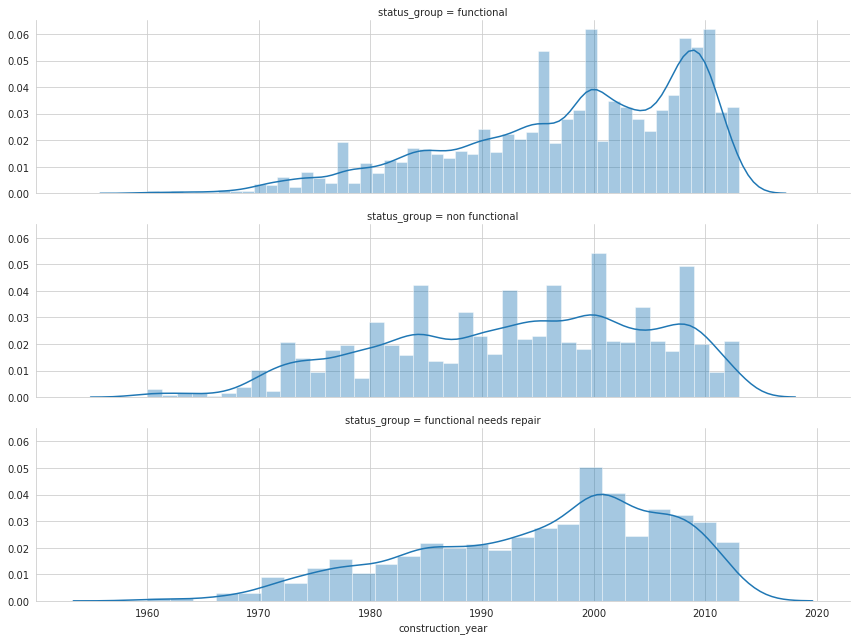

In [40]:
g = sns.FacetGrid(X_train_new, row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year')
#g.axes[0,0].plot(x, pdf, linewidth = 2, color = 'red')

**Comparing to Original Dist**

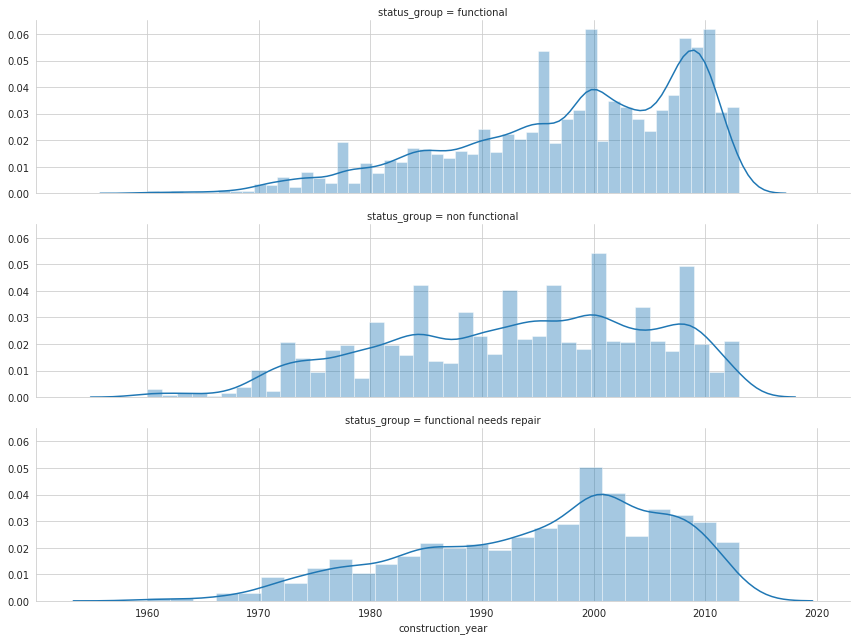

In [41]:
g = sns.FacetGrid(X_train_raw[X_train_raw['construction_year'] > 0], row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year')

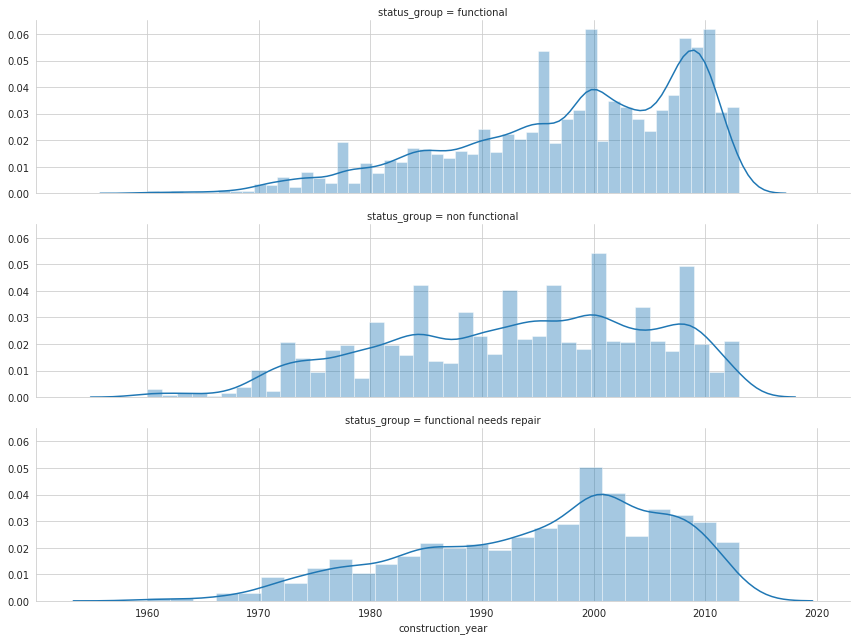

In [42]:
g = sns.FacetGrid(X_train_new, row = 'status_group', aspect = 4)
g = g.map(sns.distplot, 'construction_year')
#g.axes[0,0].plot(x, pdf, linewidth = 2, color = 'red')

Awesome, I'm really happy with this. I'll try this new imputation function to see if it provides better results for the modeling.